# Maps around reservoirs

## To-dos
- [ ] trend maps for xarray data
- [x] area_subset of GRACE data (instead of point subset)
- [x] area_subset of IMERG data
- [x] area_subset of precip data
- [ ] 3 panel plot

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rxr

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets

In [3]:
fw_DA = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip_DA = load_data.load_IMERG()

In [5]:
dam_name = 'Indirasagar'
subset_gpd = area_subsets.check_for_multiple_dams(dam_name,res_shp)
precip_multi , precip_full = area_subsets.precip_shape_subset(
                     subset_gpd,
                     precip_DA,
                     buffer_val=0.25,
                     crs_code=4326)

fw_multi , fw_full = area_subsets.cygnss_shape_subset(
                     subset_gpd,
                     fw_DA,
                     buffer_val=0.25,
                     crs_code=4326)
cmwe_multi , mascon_ts , cmwe_full = area_subsets.grace_shape_subset(
                        subset_gpd,
                        grace_dict,
                        buffer_val=0) 

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


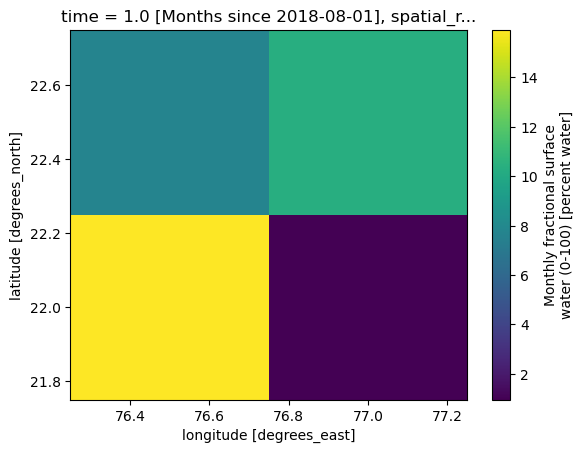

In [7]:
fw_multi.isel(time=1).plot()

## Subset gpd by shp file

In [ ]:
def check_for_multiple_dams(dam_name,res_shp):
    """
    Inputs
    ------

    Outputs
    -------
    GeoDataFrame of reservoir(s) with the dam

    """
    dam_row = (res_shp['DAM_NAME'].str.lower())==(dam_name.lower())
    n_rows = dam_row.sum()
    if n_rows == 0:
        print('Dam name not found')
    elif n_rows > 1:
        print('Dam name',dam_name,'is redundant.',n_rows,'entires found.')
    return res_shp[dam_row]

In [ ]:
def grace_shape_subset(dam_name,res_shp,grace_dict,buffer_val=0):
    shape_row = check_for_multiple_dams(dam_name,res_shp)
    shape_poly = shape_row['geometry'].buffer(buffer_val).unary_union
    bool_series = grace_dict['mascon'].intersects(shape_poly)
    subsetted_mascon = grace_dict['mascon'][bool_series]
    subsetted_cmwe = grace_dict['cmwe'][bool_series]
    return subsetted_cmwe , subsetted_mascon

In [ ]:
cmwe_i , mascon_i = grace_shape_subset('Indirasagar',res_shp,grace_dict)

mascon_i.plot()

## Test subset xarray by shp file (precip)

In [4]:
def xr_shape_subset(dam_name,res_shp,input_xr,buffer_val=0,crs_code = 4326):
    subset_gpd = area_subsets.check_for_multiple_dams(dam_name,res_shp)
    # Add crs to xr
    full_rxr = input_xr.rio.write_crs(crs_code)

    # Grab coordinate names
    x_name = [dim for dim in list(input_xr.dims) if 'lon' in dim][0]
    y_name = [dim for dim in list(input_xr.dims) if 'lat' in dim][0]

    # Set spatial dimensions to xr
    full_rxr.rio.set_spatial_dims(x_name,y_name,inplace=True)

    # Apply shp subset
    clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
    return clip_rxr

In [5]:
precip_plot = xr_shape_subset('Indirasagar',res_shp,precip_DA,buffer_val=0.25)
# precip_plot[0,:,:].plot()

/tmp/ipykernel_21748/834678012.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


: 

: 

In [ ]:
# Input values
input_xr = precip_DA
crs_code = 4326
input_gpd = area_subsets.check_for_multiple_dams('Indirasagar',res_shp)

# Add crs to xr
test_rxr0 = input_xr.rio.write_crs(crs_code)

# Grab coordinate names
x_name = [dim for dim in list(input_xr.dims) if 'lon' in dim][0]
y_name = [dim for dim in list(input_xr.dims) if 'lat' in dim][0]

# Set spatial dimensions to xr
test_rxr0.rio.set_spatial_dims(x_name,y_name,inplace=True)

# Apply shp subset
test_clip = test_rxr0.rio.clip(input_gpd.geometry.buffer(1) , input_gpd.crs)
test_clip[1,:,:].plot()

## Test subset xarray by shp file (CYGNSS fw)

From rioxarray documentation here (https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html#xarray), I should be able to use the existing loading function xr.open_datarray() and be compatible with rioxarray functionality.

rio.clip() kind of working. Produces an error if an empty spatial subset.

In [ ]:
test_row = area_subsets.check_for_multiple_dams('Indirasagar',res_shp)
# test_poly = test_row['geometry'].buffer(0.1).unary_union
test_row.geometry

In [ ]:
test_rxr = fw_DA.rio.write_crs(4326)
# test_rxr.rio.to_raster('../../scratch/ann_scheliga/rxr_rasters/test_rxr.tif')
test_rxr.rio.set_spatial_dims('lon','lat',inplace=True)

In [ ]:
# rio.clip_box() works

test_boxclip = test_rxr.rio.clip_box(76.42467457600003, 21.907250000000033, 76.90174206500012, 22.4733543750001)
test_boxclip[:,:,0].plot()
# 76.72987 21.99

In [ ]:
test_clip = test_rxr.rio.clip(test_row.geometry.buffer(1) , test_row.crs)
test_clip[:,:,1].plot()

## Scratchwork

In [ ]:
## Trying out plotting functionality

tws = grace_dict['cmwe'].T
x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
y_tws = tws
initial_tws_slopes = time_series_calcs.linregress_wrap(x_tws,y_tws)
print(initial_tws_slopes.head())

initial_tws_slopes_gdf = gpd.GeoDataFrame(pd.concat([initial_tws_slopes , grace_dict['mascon']],axis=1))

# fig , ax = plt.subplots(figsize=(12,8))
# input_gdf = initial_tws_slopes_gdf
# count = 0
# plotting_functions.statsig_map(input_gdf,ax,count, pie_row = [0.5,0.4,0.1])

In [ ]:
test=grace_dict['cmwe']
test.apply(time_series_calcs.linregress_wrap,axis=1,args=(x_tws))

In [ ]:
test.apply(np.mean,axis=1)

In [ ]:
## works for pd.DataFrame and linregress_wrap
# is necessary to create the x_values for linregress
def spatial_apply_func(input_df,func):
    tws = input_df.T
    x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
    y_tws = tws
    initial_tws_slopes = func(x_tws,y_tws)
    return initial_tws_slopes
spatial_apply_func(grace_dict['cmwe'],time_series_calcs.linregress_wrap)

In [ ]:
spatial_apply_func(grace_dict['cmwe'].head(12),max)

In [ ]:
coords_oi = reservoir_name_to_point('Nouzhadu')

test = grace_point_subset(coords_oi)
print(test[1].iloc[0]['geometry'].exterior)
test[1]['geometry'].explore()

In [ ]:
res_shp.crs